# Sweep: Notebook to JIRA

### Welcome!

#### This notebook shows how can you access JIRA in a Jupyter notebook using *Sweep*.

Sweep:
* Authenticates to and accesses JIRA
* Sends requests to the JIRA REST API and reformats the results
* Defines the result of a query to JIRA as a *QueryFrame* object which contains all date you might want to get from it
* Partially caches results in a local database for speeding up repeatedly querying
* Provides some utilities for dealing with the data
* Sweep offers data in the convenient pandas DataFrame format

You will now be guided through the basics of Sweep step by step.

## Auto-reload

Sweep is under construction. While mostly pandas and matplotlib related calls are made in notebook cells,
the underlying python code is adapted. 'autoreload' will automatically re-import changed python files
so after a change in the underlying Sweep code all that is needed is re-execute the cell you are working on.

In [1]:
%load_ext autoreload
%autoreload 2

## Basic imports

Below, standard pandas, numpy, and matplotlib imports.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [3]:
# Set to a different value if you want all rows to be displayed of dataframes with more rows than this setting
pd.set_option('display.max_rows', 999)

## Let's import and initialize Sweep

First we import Sweep:
```python
from jiranb import jiranb
```

Here `jiranb` stands for "JIRA notebook". (Never mind, the `import Config`, that will be removed in the near future.)

We create an instance `jnb` of the JIRA notebook, which will:
* Initialize our connection with JIRA
* Channel functions calls through Sweep

Please note:
>At the start of the initialization a configuration file is read. Please, see the documentation for configuring Sweep!

In [4]:
from jiranb import jiranb
import Config
jnb = jiranb()

Configuration:
* Reading configuration from: /Users/cjr/PycharmProjects/portfolio-sweep/src/../../sweep.yaml (/Users/cjr/PycharmProjects/sweep.yaml)
* Portfolio: Sweep - PyCharm dir
* Input mode: jira (https://sweep.atlassian.net/)
* Loaded statuses: Backlog, Selected for Development, In Progress, Done
* Loaded plugins: HelloWorldPlugin, AbstractPlugin, AggregateDataPlugin, BurnupPlugin, CumulativeFlowPlugin, CycleTimePlugin, DetailsPlugin, IssueTypesPlugin, IssuesPlugin, TimeSpentPlugin, TreeMapPlugin
* Configured plugins: HelloWorldPlugin, DetailsPlugin, AggregateDataPlugin, TreeMapPlugin, CumulativeFlowPlugin, CycleTimePlugin, BurnupPlugin, TimeSpentPlugin, IssueTypesPlugin, IssuesPlugin
* Template input directory: service.web (package)
* Report output directory: /Users/cjr/reports


## Let's query JIRA

### JQL and the Sweep QueryFrame

We take our JIRA notebook instance and call it with a JIRA JQL string.

> JQL stands for Jira Query Language and is the most powerful and flexible way to search for your issues in Jira. JQL is for everyone: developers, testers, agile project managers, and business users.

If you need to learn more about the syntax of JQL, please check the [Atlassian website](https://www.atlassian.com/blog/jira-software/jql-the-most-flexible-way-to-search-jira-14).

We store the result of the query in a variable named `qf`, which stands for `QueryFrame`. This is a notion unique to Sweep.

In [5]:
qf = jnb.jql('project=PLAN')

## Basic issue data

When we use "search" in JIRA the result is *always* a list of issues. In the JIRA search user interface we might 
configure columns, change sorting order or paginate, but we we not get any other result than a list of issues.

The `QueryFrame` is also primarily a list of issues, but broken into several dataframes. The first one is called `issuedata` and looks very much like the query result we see in JIRA search (but without the UX).

In [6]:
qf.issuedata.head()

,key,status,summary,description,created,updated,issuetype,timeoriginalestimate,timespent,creator,reporter,assignee
0,PLAN-40,Backlog,Encapsulate starting django,As a user\r\nI can start Django with the same ...,2019-12-05 06:25:43.160,2019-12-05 06:52:33.300,Story,7200.0,NaN,Cees Roele,Cees Roele,None
1,PLAN-39,Backlog,Alternative: allow configuration of initiative...,Allow configuration of initiatives and sagas i...,2019-12-04 18:16:17.600,2019-12-04 18:17:04.580,Story,28800.0,NaN,Cees Roele,Cees Roele,None
2,PLAN-38,Done,Simplify reading of configuration file,Use paths like /reports/templatedir rather tha...,2019-12-04 08:10:47.310,2019-12-04 18:21:14.130,Task,3600.0,3600.0,Cees Roele,Cees Roele,None
3,PLAN-37,In Progress,Create cycle time chart,None,2019-12-04 08:09:12.810,2019-12-04 18:21:53.460,Story,14400.0,10800.0,Cees Roele,Cees Roele,None
4,PLAN-36,Done,sweep.yaml read in different locations by Djan...,Read sweep.yaml from single location.,2019-11-25 05:42:39.670,2019-12-04 18:20:45.450,Bug,NaN,3600.0,Cees Roele,Cees Roele,None


### A simple pie chart

Given the above dataframe we can now execute standard operation including invoking matplotlib.

Let's create a simple pie chart indicating the share of each issuetype in the total number of issues.
First we leave out most fields and group the data by `issuetype`, of which we count the occurrences.

In [7]:
pie_df = qf.issuedata[['issuetype','key']].groupby('issuetype').count()
pie_df

,key
issuetype,
Bug,1
Epic,6
Story,20
Sub-task,2
Task,8


And create the pie chart. That's all!

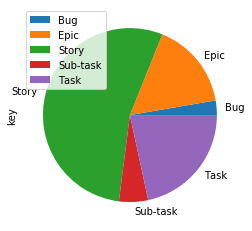

In [8]:
pie_df.plot.pie(y='key')
plt.show()

## Historical data

Historical data on issues is stored as "logs":
* `changelog`: contains the changes made to all fields and basically contains the information: "On date & time X, user U replaced the old value p of field Y with a new value q".
* `worklog`: contains similar logs as the changelog, but now on who logged work on what date for the issue

On the positive side, JIRA's storage of this data in logs makes it possible to reconstruct all states of the issue back to its creation.

On the negative side, it requires iteration in a script to retrieve the data.

In Sweep we create a dataframe containing part of the information in the logs. We are not (now) interested in who did what on what date. It is good enough to know what is the status of an issue per day, which we can extract from the `changelog`. (We ignore other fields for now and we ignore the `worklog`).

The historical information can be accessed by the `timedata` attribute of the `QueryFrame`.

In [9]:
qf.timedata

,date,key,status
0,2019-09-09,PLAN-40,None
1,2019-09-09,PLAN-39,None
2,2019-09-09,PLAN-38,None
3,2019-09-09,PLAN-37,None
4,2019-09-09,PLAN-36,None
...,...,...,...
3177,2019-12-03,PLAN-5,Done
3178,2019-12-03,PLAN-4,Done
3179,2019-12-03,PLAN-3,Done
3180,2019-12-03,PLAN-2,Done


This data is constructed as follows:
1. The start date is defined as the first `created` date of any of the group of issues
2. The end date is defined as the latest `updated` date of any of the group of issues
3. We define our period as a range of dates between the start and end dates
4. For every date, for every key in our result set, we mark the status of the issue at that date
5. If the issue doesn't have a status at that date, which will happen if it hasn't been created yet, the status will get the value `None`.

### A stacked area chart

A standard diagram for tracking progress of work that is represented in JIRA is the ["Cumulative Flow Diagram"](https://yodiz.com/help/cumulative-flow-diagram-cfd/):

> A Cumulative Flow Diagram is an area chart that shows the progress of a project work items for a particular period. This graph is a fundamental tool to visualize project progress and helps to spot potential problems. This diagram shows the count of Backlog items and pace of their progress for the selected past number of days. This is an advanced version of Burn-Up graph.

We can create it with the date we now have.

Translating the above in the notions of our data: the cumulative flow diagram is to show how many issues are in each `status` at any date.

So, let's group by `date` and `status`.

In [10]:
aggregate_df = qf.timedata.groupby(by=['date','status'], as_index=False).count()
aggregate_df.head()

,date,status,key
0,2019-09-10,Backlog,1
1,2019-09-10,Done,3
2,2019-09-10,In Progress,2
3,2019-09-10,Selected for Development,1
4,2019-09-11,Backlog,1


Now we need to pivot the status so we can use the date as an index. 

In some cells we will get an empty value, e.g. because at the first day no issue has been completed yet or because at some point no more issues are selected for developed. We set the values of these cells to 0.

In [11]:
res = aggregate_df.pivot(index='date', columns='status', values='key').fillna(0)
res.head()

status,Backlog,Done,In Progress,Selected for Development
date,,,,
2019-09-10,1.0,3.0,2.0,1.0
2019-09-11,1.0,4.0,2.0,1.0
2019-09-12,1.0,4.0,2.0,1.0
2019-09-13,1.0,4.0,2.0,1.0
2019-09-14,1.0,4.0,2.0,1.0


The order of the columns resulting from the pivot is not the order in which we want to see the status in our area chart, so we reset the data frame with a list of the statuses used by the system.

In [12]:
statuses = Config.config.statuses
statuses

['Backlog', 'Selected for Development', 'In Progress', 'Done']

In [13]:
res = res[statuses]

Now we are ready to create the diagram.

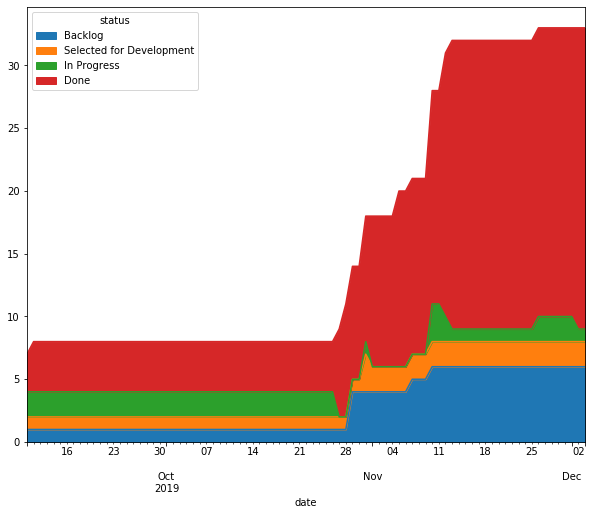

In [14]:
res.plot.area(figsize=(10,8))
plt.show()

## Additional functionality

### Issue data in a table

You can quickly get the fields of an issue by using the issue key as an index to the `QueryFrame`:

In [15]:
qf['PLAN-7']

field,value
key,PLAN-7
summary,Retrieve issues for Initiative
description,Retrieve issues linked to an Initiative Acceptance criteria: Issues are printed to the console.
issuetype,Task
created,2019-09-09T20:39:43.646+0200
updated,2019-11-04T21:38:01.919+0100
assignee,None
creator,Cees Roele
timeoriginalestimate,3600
timespent,14400


The object returned is an `IssueData` object from Sweep.

In [16]:
type(qf['PLAN-7'])

data.JiraObjectData.IssueData

The values of the individual fields can be obtained like this:

In [17]:
qf['PLAN-7']['timespent']

14400

### Meta-data: fields

When scripting with JIRA data, that is, not using it through the user interface, one needs to invoke fields by
their exact names. These are not normally visible and different configurations might have different keys.

The way to get all relevant data on all fields is to query the JIRA REST API for it, which returns a JSON file.

To make life easier for when writing in the JIRA notebook, you can call the `jnb` instance to get info on
all fields represented in a dataframe.

In [18]:
jnb.fields(shortlist=False).head()

,id,key,name,custom,orderable,navigable,searchable,clauseNames,schema
0,statuscategorychangedate,statuscategorychangedate,Status Category Changed,False,False,True,True,['statusCategoryChangedDate'],"{'type': 'datetime', 'system': 'statuscategory..."
1,issuetype,issuetype,Issue Type,False,True,True,True,"['issuetype', 'type']","{'type': 'issuetype', 'system': 'issuetype'}"
2,parent,parent,Parent,False,False,True,False,['parent'],None
3,timespent,timespent,Time Spent,False,False,True,False,['timespent'],"{'type': 'number', 'system': 'timespent'}"
4,project,project,Project,False,False,True,True,['project'],"{'type': 'project', 'system': 'project'}"


Or, the default, ignoring the values you likely don't need:

In [19]:
jnb.fields().head()

,key,name,schema
0,statuscategorychangedate,Status Category Changed,"{'type': 'datetime', 'system': 'statuscategory..."
1,issuetype,Issue Type,"{'type': 'issuetype', 'system': 'issuetype'}"
2,parent,Parent,None
3,timespent,Time Spent,"{'type': 'number', 'system': 'timespent'}"
4,project,Project,"{'type': 'project', 'system': 'project'}"


## Summary

### Manipulate the data in clear language
With Sweep you can access JIRA with results coming in a format that allows easy manipulation 
in the vocabulary of data transformations. This gives greater clarity to what is being done to
the data than when trying to accomplish the same by writing programming code directly.

### Quick and easy visualization
Additionally, having the data available in dataframes allows for the power of the combination
of pandas and matplotlib to be unleashed for quick and easily visualization.
